# 数据预处理

## 读取数据

In [1]:
# 读取数据
lung.cancer <- read.csv("lung-cancer.csv")

## 处理特征

In [2]:
# 数值型变量
num_columns <- c(
    "Age.recode.with.single.ages.and.90.",
    "Tumor.Size.Summary..2016..",
    "Regional.nodes.positive..1988..",
    "Regional.nodes.examined..1988..",
    "Months.from.diagnosis.to.treatment",
    "Survival.months"
)

# 将非数值型变量转化为 factor
lung.cancer[, !names(lung.cancer) %in% num_columns] <- lapply(lung.cancer[, !names(lung.cancer) %in% num_columns], as.factor)

# 记录事件
lung.cancer$Event <- (lung.cancer$Year.of.death.recode != "Alive at last contact")

# 去除 Tumor size 的缺失值
lung.cancer <- lung.cancer[lung.cancer$Tumor.Size.Summary..2016..<990, ]

# 去除 censored data
lung.cancer <- lung.cancer[lung.cancer$Year.of.death.recode != "Alive at last contact", ]

# 去除淋巴结数量缺失的数据
lung.cancer <- lung.cancer[lung.cancer$Regional.nodes.positive..1988..<=90, ]
lung.cancer <- lung.cancer[lung.cancer$Regional.nodes.examined..1988..<=90, ]

# 假定死亡发生在月末
lung.cancer$Survival.months <- lung.cancer$Survival.months + 1

# 按照 Survival.months 排序
lung.cancer <- lung.cancer[order(lung.cancer$Survival.months), ]

# 挑选需要的特征
columns_to_select <- c(

    # ------- 基本信息 ------- #
   #"Patient.ID",                                            # 病人ID
    "Age.recode.with.single.ages.and.90.",                   # 年龄 <数值型>
    "Sex",                                                   # 性别
    "Race.recode..W..B..AI..API.",                           # 种族
    "Rural.Urban.Continuum.Code",                            # 所在县
    "Marital.status.at.diagnosis",                           # 确诊时婚姻状况
    "Median.household.income.inflation.adj.to.2021",         # 所在县的收入数据

    # ------- 肿瘤相关信息 ------- #
    "Primary.Site",                                          # 原发部位
    "Combined.Summary.Stage..2004..",                        # 癌症分期信息
   #"Behavior.code.ICD.O.3",                                 # 肿瘤行为
   #"Histology.recode...broad.groupings",                    # 癌症组织
    "Grade.Clinical..2018..",                                # 临床分级
    "Grade.Pathological..2018..",                            # 病理分级
    "Separate.Tumor.Nodules.Ipsilateral.Lung.Recode..2010..",# 肺部同侧肿瘤结节
    "Visceral.and.Parietal.Pleural.Invasion.Recode..2010..", # 胸膜侵犯
    "Tumor.Size.Summary..2016..",                            # 肿瘤大小 <数值型>
    "Regional.nodes.positive..1988..",                       # 区域positive淋巴结 <数值型>
    "Regional.nodes.examined..1988..",                       # 区域examined淋巴结 <数值型>
   #"EOD.Primary.Tumor..2018..",                             # 确诊时的肿瘤情况 https://staging.seer.cancer.gov/eod_public/input/3.1/lung/eod_primary_tumor/?breadcrumbs=(~schema_list~),(~view_schema~,~lung~)
   #"EOD.Regional.Nodes..2018..",                            # 确诊时的淋巴结情况 https://staging.seer.cancer.gov/eod_public/input/3.1/lung/eod_regional_nodes/?breadcrumbs=(~schema_list~),(~view_schema~,~lung~)
    "EOD.Mets..2018..",                                      # 用于在诊断时对远处转移受累部位进行分类 https://staging.seer.cancer.gov/eod_public/input/3.1/lung/eod_mets/?breadcrumbs=(~schema_list~),(~view_schema~,~lung~)

    # ------- 治疗信息 ------- #
    "Months.from.diagnosis.to.treatment",                    # 确诊到治疗的月数 <数值型>
    "Radiation.recode",                                      # 辐射治疗
    "Chemotherapy.recode..yes..no.unk.",                     # 化学治疗
    "RX.Summ..Surg.Rad.Seq",                                 # 治疗顺序
    "RX.Summ..Systemic.Sur.Seq..2007..",                     # 治疗顺序

    # ------- 时间线 ------- #
    "Year.of.diagnosis",                                     # 确诊年份
   #"Year.of.follow.up.recode",                              # 跟进时间
    "Year.of.death.recode",                                  # 死亡年份
    "Survival.months",                                       # 存活月数 <数值型>

    # ------- 其他 ------- #
    #"Derived.EOD.2018.T..2018..",                           
    #"Derived.EOD.2018.N..2018..",                           
    #"Derived.EOD.2018.M..2018..",                           
    #"Derived.EOD.2018.Stage.Group..2018..",                 
    ""
)
lung.cancer <- lung.cancer[, names(lung.cancer) %in% columns_to_select]
str(lung.cancer)

'data.frame':	790 obs. of  24 variables:
 $ Age.recode.with.single.ages.and.90.                   : int  78 81 66 64 64 73 79 64 65 75 ...
 $ Sex                                                   : Factor w/ 2 levels "Female","Male": 2 1 1 2 1 2 1 2 1 2 ...
 $ Race.recode..W..B..AI..API.                           : Factor w/ 4 levels "American Indian/Alaska Native",..: 4 4 4 4 4 4 4 4 3 4 ...
 $ Rural.Urban.Continuum.Code                            : Factor w/ 5 levels "Counties in metropolitan areas ge 1 million pop",..: 1 1 1 2 2 2 4 4 2 4 ...
 $ Marital.status.at.diagnosis                           : Factor w/ 6 levels "Divorced","Married (including common law)",..: 2 6 2 4 1 2 6 2 2 2 ...
 $ Median.household.income.inflation.adj.to.2021         : Factor w/ 10 levels "< $35,000","$35,000 - $39,999",..: 10 10 10 9 10 9 6 6 9 6 ...
 $ Primary.Site                                          : Factor w/ 6 levels "340","341","342",..: 4 2 4 2 1 2 2 4 4 4 ...
 $ Combined.Summary.Stage..2004

# 描述性统计

# 数据建模

In [3]:
summarize.model <- function(model, filename){
    model.summary <- summary(model)
    output <- capture.output(model.summary)
    writeLines(output, filename)
}

## 线性模型

### 模型拟合

In [4]:
linear.model <- lm(Survival.months ~ ., data=lung.cancer)
summarize.model(linear.model, "./model-summary/linear_model_summary.txt")

### 预测图像

In [5]:
y_pred <- predict(linear.model, newdata = lung.cancer)
y_true <- lung.cancer$Survival.months
result_df <- data.frame(Actual = y_true, Predicted = y_pred)
library(ggplot2)
linear.prediction <- ggplot(result_df, aes(x = 1:length(y_true))) +
                     geom_line(aes(y = Actual, color = "Actual"), linewidth = 1) +
                     geom_line(aes(y = Predicted, color = "Predicted"), linetype = "dashed", linewidth = 1) +
                     labs(title = "Actual vs Predicted Over Observations",
                     x = "Observations", y = "Values") +
                     scale_color_manual(values = c("Actual" = "blue", "Predicted" = "red"))
ggsave("./figures/linear_prediction.png", linear.prediction, width = 8, height = 6, dpi = 300)

## 广义线性模型(y分布如何选择?)

### 模型拟合

In [6]:
library(MASS)
glinear.model <- glm(Survival.months ~ ., data=lung.cancer, family = gaussian) # 负二项分布
summarize.model(glinear.model, "./model-summary/generalized_linear_model_summary.txt")

### 预测图像

In [7]:
y_pred <- predict(glinear.model, newdata = lung.cancer)
y_true <- lung.cancer$Survival.months
result_df <- data.frame(Actual = y_true, Predicted = y_pred)
glinear.prediction <- ggplot(result_df, aes(x = 1:length(y_true))) +
                     geom_line(aes(y = Actual, color = "Actual"), linewidth = 1) +
                     geom_line(aes(y = Predicted, color = "Predicted"), linetype = "dashed", linewidth = 1) +
                     labs(title = "Actual vs Predicted Over Observations",
                     x = "Observations", y = "Values") +
                     scale_color_manual(values = c("Actual" = "blue", "Predicted" = "red"))
ggsave("./figures/glinear_prediction.png", glinear.prediction, width = 8, height = 6, dpi = 300)

## box-cox

### 模型拟合

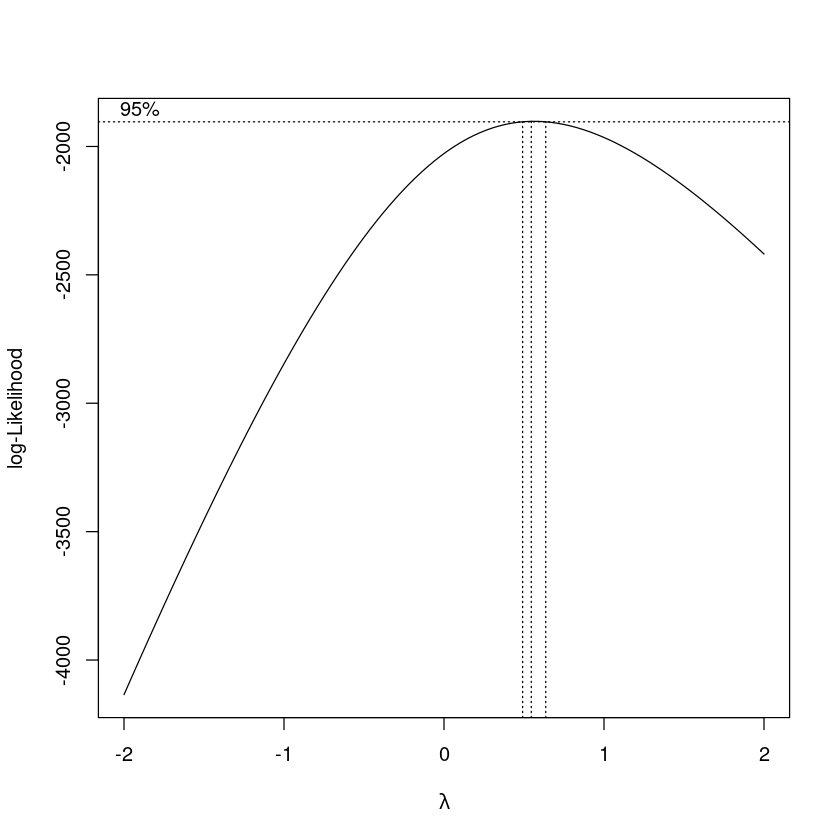

In [8]:
boxcox.model <- boxcox(Survival.months ~ ., data = lung.cancer)
lambda <- boxcox.model$x[which.max(boxcox.model$y)]
bclinear.model <- lm((Survival.months^lambda - 1)/lambda ~ ., data = lung.cancer)
summarize.model(bclinear.model, "./model-summary/boxcox_linear_model_summary.txt")

### 预测图像

In [9]:
y_pred <- predict(bclinear.model, newdata = lung.cancer)
y_true <- (lung.cancer$Survival.months^lambda - 1)/lambda
result_df <- data.frame(Actual = y_true, Predicted = y_pred)
bclinear.prediction <- ggplot(result_df, aes(x = 1:length(y_true))) +
                     geom_line(aes(y = Actual, color = "Actual"), linewidth = 1) +
                     geom_line(aes(y = Predicted, color = "Predicted"), linetype = "dashed", linewidth = 1) +
                     labs(title = "Actual vs Predicted Over Observations",
                     x = "Observations", y = "Values") +
                     scale_color_manual(values = c("Actual" = "blue", "Predicted" = "red"))
ggsave("./figures/bclinear_prediction.png", bclinear.prediction, width = 8, height = 6, dpi = 300)

## 岭回归

### 模型拟合

In [10]:
library(glmnet)
lung.cancer.x <- lung.cancer[, !(names(lung.cancer) %in% c("Survival.months"))]
lung.cancer.y <- lung.cancer$Survival.months
rlinear.model <- glmnet(lung.cancer.x, lung.cancer.y, alpha = 0, lambda = seq(from = 1, to = 1000, by = 1))

Loading required package: Matrix

Loaded glmnet 4.1-8



### 预测图像

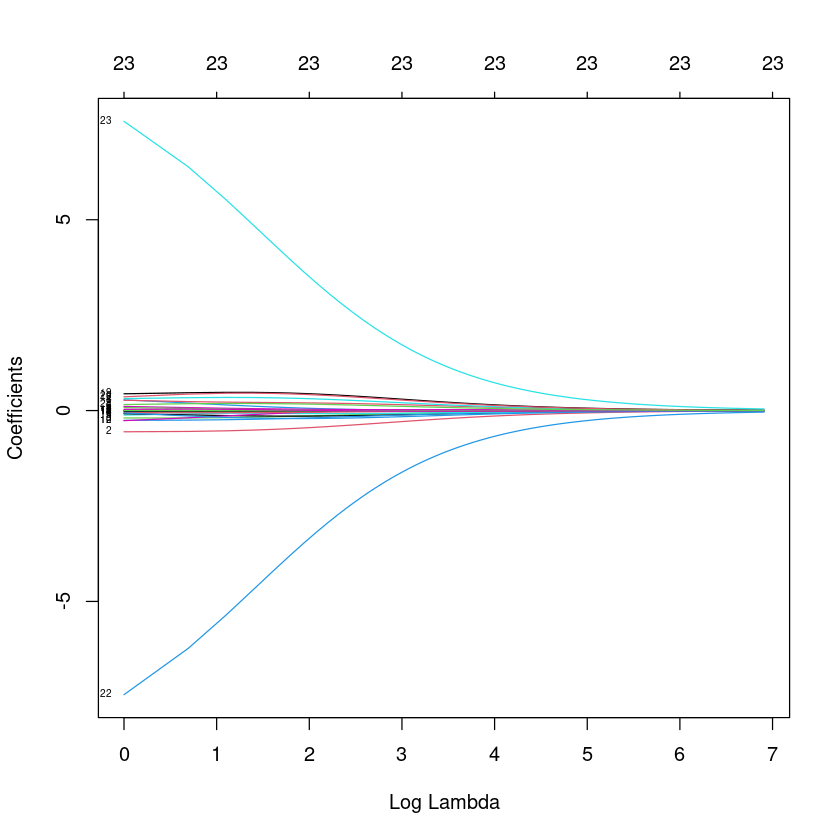

In [11]:
plot(rlinear.model, xvar = "lambda", label = TRUE)